## №1 Проверка доверительных интервалов

In [1]:
# Подключим нужные для базовых операций библиотеки
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import tqdm
import seaborn as sns

# Подключим пакеты для использования OLS метода и тестов
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, \
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Подгрузим полезные функции
from utils import *

In [2]:
# Определим параметры выборки для задачи мультиколлинеарности
# Создадим удобный словарь, чтобы передавать его в функцию
dist_params = dict(

    # Зададим параметры распределения факторов
    x1_mean = 100.0,
    x1_std = 250.0,
    x2_mean = 20.0,
    x2_std = 300.0,
    x3_mean = 30.0,
    x3_std = 450.0,
    corr_12 = 0,
    corr_23 = 0.8,
    corr_13 = 0,
    
    # Зададим параметры распределения ошибки
    e_mean = 0.0,
    e_std = 50000.0,

    # Укажем размер выборки
    N = 1000,

    # Зададим действительные параметры модели
    beta0 = 500.0,
    beta1 = -6.7,
    beta2 = 2.3,
    beta3 = 17.7
)

# Установим стартовую точку для алгоритма генерации случайных чисел
RANDOM_SEED = 42

b_1_inside = 0
b_2_inside = 0
b_3_inside = 0
tests = 10_000

In [3]:
for i in tqdm.trange(tests):
    data = gen_data(y_type='multivariate', params=dist_params, seed=RANDOM_SEED)
    _, model = train_model(data, target='y', feature_names=['x1', 'x2', 'x3'])
    intervals = model.conf_int()

    # Получим доверительный интервал для параметра 
    b_1_interval = intervals.loc['x1']
    b_2_interval = intervals.loc['x2']
    b_3_interval = intervals.loc['x3']

    # Проверим, попадает ли истинное значение в доверительный интервал
    if b_1_interval[0] <= dist_params['beta1'] <= b_1_interval[1]:
        b_1_inside += 1
    if b_2_interval[0] <= dist_params['beta2'] <= b_2_interval[1]:
        b_2_inside += 1
    if b_3_interval[0] <= dist_params['beta3'] <= b_3_interval[1]:
        b_3_inside += 1

100%|██████████| 10000/10000 [00:36<00:00, 271.04it/s]


In [4]:
inside_percent_b_1 = 100 * b_1_inside / tests
inside_percent_b_2 = 100 * b_2_inside / tests
inside_percent_b_3 = 100 * b_3_inside / tests

print(f"Процент попаданий  b_1 в доверительный интервал ^b_1 с уровнем значимости 5%: {inside_percent_b_1} %")
print(f"Процент попаданий  b_2 в доверительный интервал ^b_2 с уровнем значимости 5%: {inside_percent_b_2} %")
print(f"Процент попаданий  b_3 в доверительный интервал ^b_3 с уровнем значимости 5%: {inside_percent_b_3} %")

assert np.isclose(inside_percent_b_1, 95, rtol=0, atol=5), "Процент попадания в доверительный интервал для b_1 не соответствует ожидаемым значениям."

Процент попаданий  b_1 в доверительный интервал ^b_1 с уровнем значимости 5%: 100.0 %
Процент попаданий  b_2 в доверительный интервал ^b_2 с уровнем значимости 5%: 100.0 %
Процент попаданий  b_3 в доверительный интервал ^b_3 с уровнем значимости 5%: 100.0 %


## 2. Logit модель на датасете [Heart Disease Health Indicators Dataset](https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset/data)

In [5]:
# Подгрудаем датасет
heart_deaseases_dt = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
target = heart_deaseases_dt['HeartDiseaseorAttack']
features = heart_deaseases_dt.drop('HeartDiseaseorAttack', axis=1)
display(heart_deaseases_dt)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [6]:
classes_weight = compute_class_weight(class_weight="balanced", classes=np.unique(target), y=target)
model = LogisticRegression(max_iter=1000, class_weight=dict(zip(np.unique(target), classes_weight)))
model.fit(features, target)

LogisticRegression(class_weight={0.0: 0.5519894511003669,
                                 1.0: 5.308667810655841},
                   max_iter=1000)

In [7]:
predict_proba = model.predict_proba(features)[:, 1]
predict = model.predict(features)

In [8]:
print(f"Accuracy={accuracy_score(target, predict)}")

Accuracy=0.7523375906654053


In [9]:
print(classification_report(target, predict))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85    229787
         1.0       0.25      0.80      0.38     23893

    accuracy                           0.75    253680
   macro avg       0.61      0.77      0.61    253680
weighted avg       0.90      0.75      0.80    253680



In [10]:
fpr, tpr, thresholds = roc_curve(target, predict_proba)

Roc-auc=0.7714895202906562


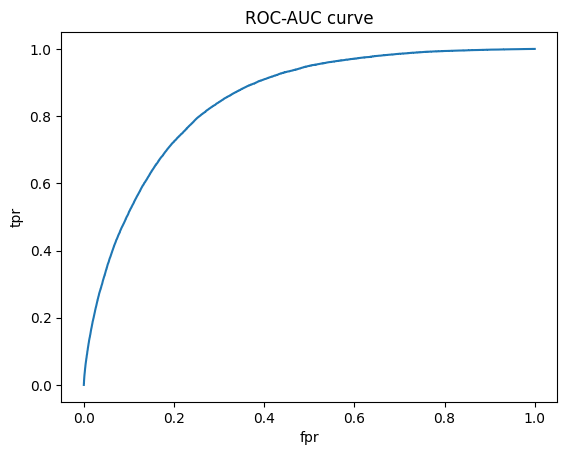

In [11]:
plt.plot(fpr, tpr)
plt.title('ROC-AUC curve')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot()
print(f"Roc-auc={roc_auc_score(target, predict)}")

[]

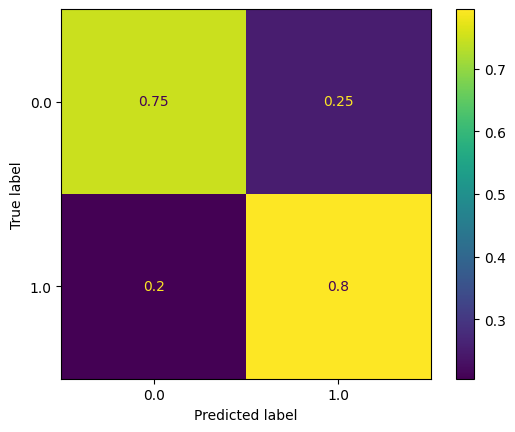

In [12]:
ConfusionMatrixDisplay.from_predictions(target, predict, normalize='true')
plt.plot()

[]

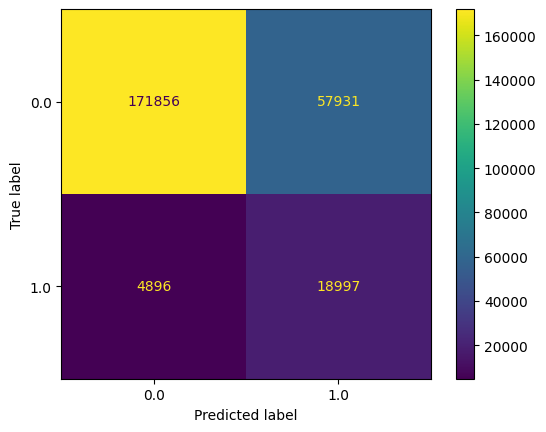

In [13]:
ConfusionMatrixDisplay.from_predictions(target, predict)
plt.plot()

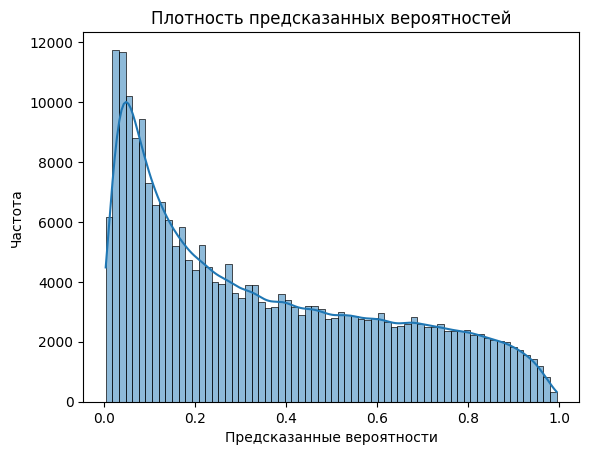

In [14]:
sns.histplot(predict_proba, kde=True)
plt.title('Плотность предсказанных вероятностей')
plt.xlabel('Предсказанные вероятности')
plt.ylabel('Частота')
plt.show()

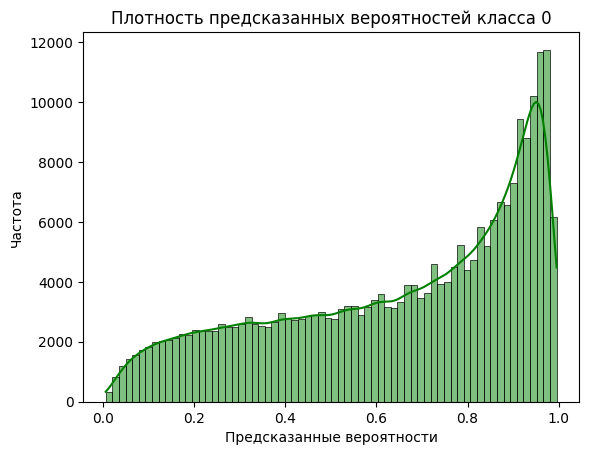

In [15]:
sns.histplot(1 - predict_proba, kde=True, color='green')
plt.title('Плотность предсказанных вероятностей класса 0')
plt.xlabel('Предсказанные вероятности')
plt.ylabel('Частота')
plt.show()

## Интерпретация:
1) О чем говорят Precision, Recall, F1_macro, ROC-AUC: \
Rrecision, Recall: Эти метрики показывают количество ошибок первого и второго рода соответственно. Видно, что среди нулевого класса Precision, выдают хорошие значения(>0.75), а среди класса 1 Precision = 0.25, что указывает на большое количество ошибок первого рода(классификатор предсказывает первый класс, но он неверен). Рассмотрим Recall, метрика выдает хорошие показатели для обоих классов, а значит, что модель допускает меньше ошибок второго рода. Т.е. модель стабильно предсказывает класс. \
F1 метрика: это средневзвешенное между Pr, R. F1 = 0.61 из-за низкого значения для первого класса, обусловленного низким Pr. \
Roc-auc: показывает насколько хорошо модель умеет различать классы и равна 0.77, что является хорошим результатом. Также метрика обуславливается площадью под графиком Auc, которая также показывает это значение.

2) 
Поставили бы корерктный диагноз людям из 100: 75


In [16]:
correct = np.floor(100 * (171856 + 18997) / 253680)
correct

75.0

Поставили бы ошибочно людям из 100: 

In [17]:
100 - correct

25.0

Сколько пациентов пропустили из 100:

In [18]:
np.floor(100 * 4896 / 253680)  

1.0

Полученная модель оказалась хорошей в рамках нашей задачи, т.к. решая эту задачу мы хотели обучаться под Recall(нам важно минимизировать количество ошибок второго рода), т.к. лучше пациент окажется на самом деле здоровым, после проведения повторного теста, чем он уйдет больным. В среднем ошибок второго рода 1 человек из ста.